In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

### Машинный эпсилон

In [2]:
def machineEpsilon(func=float):
    machine_epsilon = func(1)
    while func(1)+func(machine_epsilon) != func(1):
        machine_epsilon_last = machine_epsilon
        machine_epsilon = func(machine_epsilon) / func(2)
    return machine_epsilon_last

In [3]:
for func in [np.float16, np.float32, np.float64, np.float128]:
    print('Машинный эпсилон ' + str(func).split('.')[1].split("'")[0] + ': %0.3e' % machineEpsilon(func))

Машинный эпсилон float16: 9.766e-04
Машинный эпсилон float32: 1.192e-07
Машинный эпсилон float64: 2.220e-16
Машинный эпсилон float128: 1.084e-19


### Реализация методов

In [4]:
def C(n, k):
    if k == 0:
        return 1
    elif k > n:
        return 0
    else:
        return C(n - 1, k) + C(n - 1, k - 1)

In [5]:
# реализация схемы Горнера
def horners_method(coefs, x, flt):
    p = flt(coefs[0])
    for a in (coefs[1:]):
        p = flt(x) * flt(p) + flt(a)
    return flt(p)

In [6]:
# улучшенный базовый метод
def improved_basic_method(coefs, x, flt):
    xhat = 1
    p = flt(coefs[-1])
    for a in reversed(coefs[:-1]):
        xhat = flt(x) * flt(xhat)
        p += flt(a) * flt(xhat)
    return flt(p)

In [7]:
#@title Число бит в архитектуре мантиссы
degree = 9 # степень многочлена

transform = {16: np.float16, 32: np.float32, 64: np.float64, 128:np.float128}
bit = 64 #@param ["16", "32", "64", "128"] {type:"raw"}
flt = transform[bit]

coefs = [flt(C(degree, i)*(-2)**i) for i in range(degree+1)] 
# согласно биномиальным коэф. 
#(здесь и далее имеет место инверсия коэф.)

xs = np.arange(1.92, 2.08, 0.0001)
ys = list()
ys_horner = list()
for x in xs:
    ys.append(improved_basic_method(coefs, x, flt))
    ys_horner.append(horners_method(coefs, x, flt))

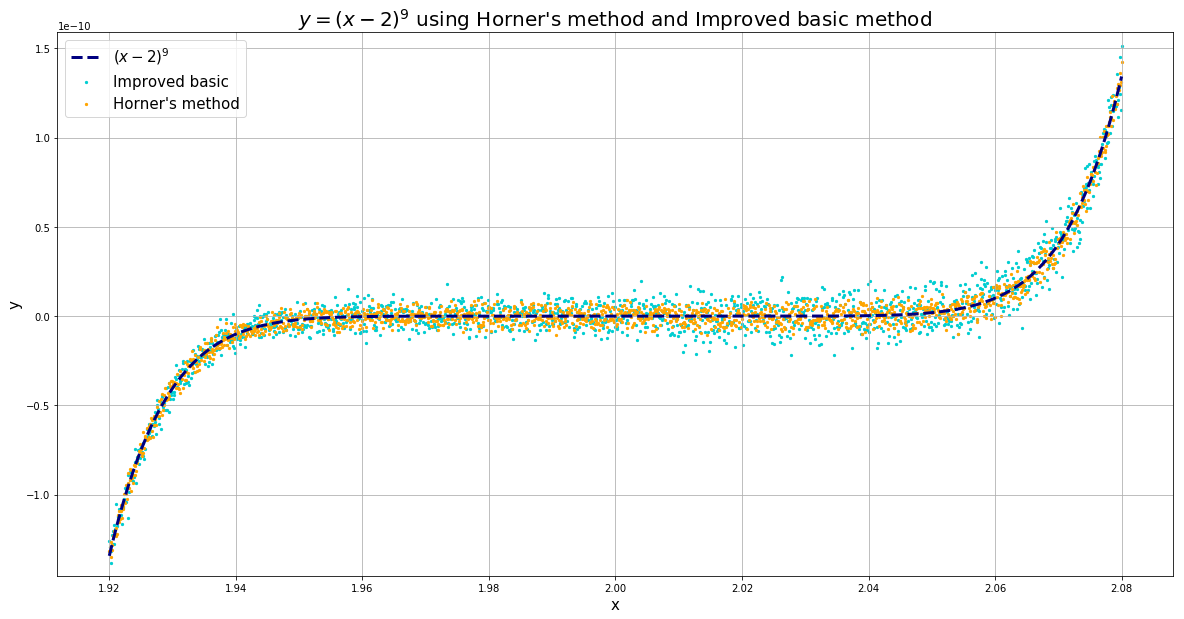

In [8]:
plt.figure(figsize=(20,10))
plt.ylim((min(ys)*1.05, max(ys)*1.05))
plt.grid(True)
plt.title("$y=(x-2)^9$ using Horner's method and Improved basic method", fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.plot(xs, [(x-2)**9 for x in xs], 'k--', c='navy', lw=3, label='$(x-2)^9$');
plt.scatter(x=xs, y=ys, s=5, c='darkturquoise', label='Improved basic');
plt.scatter(x=xs, y=ys_horner, s=5, c='orange', label="Horner's method");
plt.legend(loc='best', fontsize=15);

In [9]:
def MAE(xs, bit, method):
    flt = transform[bit]
    ys = [method(coefs, x, flt) for x in xs]
    try:
        return mean_absolute_error(ys, [np.float128((x-2)**9) for x in xs])
    except:
        return 'Overflow'

In [10]:
data = [[bit, MAE(xs, bit, horners_method), MAE(xs, bit, improved_basic_method)] for bit in [16, 32, 64, 128]]

df = pd.DataFrame(data=data, columns=['Bit', 'Horner', 'Imp.Basic'])
df

,Bit,Horner,Imp.Basic
0,16,1.426327e+01,Overflow
1,32,1.735747e-03,0.00281984
2,64,3.281264e-12,5.51063e-12
3,128,1.585178e-15,2.59342e-15


### Linear approximation (MSE minimalization)

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
lin_regr = LinearRegression()
lin_regr.fit(xs.reshape(-1,1), ys_horner);
lin_ys = lin_regr.predict(xs.reshape(-1,1))

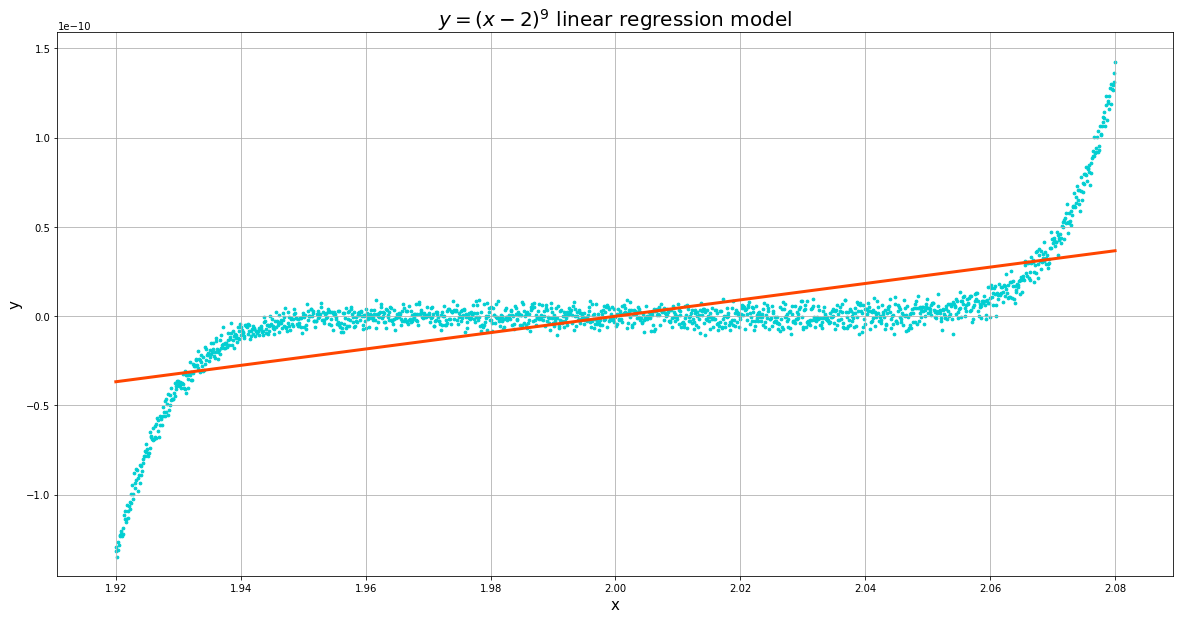

In [13]:
plt.figure(figsize=(20,10))
plt.ylim((min(ys)*1.05, max(ys)*1.05))
plt.grid(True)
plt.title("$y=(x-2)^9$ linear regression model", fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.scatter(x=xs, y=ys_horner, s=7.5, c='darkturquoise');
plt.plot(xs, lin_ys, color='orangered', linewidth=3);

In [14]:
k = (lin_ys[0]-lin_ys[-1])/(xs[0]-xs[-1])
b = lin_ys[0] - k * xs[0]
print('MSE approximation: y = %.16f*x + %.16f' %(k, b))
est_zero_x = - b / k
print('abs. error = %0.10e' %(abs(est_zero_x - 2)))
print('rel. error = %0.10e' %(100 * (est_zero_x-2)/2), '%')

MSE approximation: y = 0.0000000004585171*x + -0.0000000009170836
abs. error = 1.0763365478e-04
rel. error = 5.3816827391e-03 %
